In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


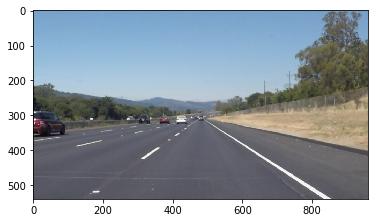

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg');
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [15]:
import math

def grayscale(img):
   
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=13):
    
    x_size = img.shape[1]
    y_size = img.shape[0]
    lines_slope_intercept = np.zeros(shape=(len(lines),2))
    for index,line in enumerate(lines):        
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - x1 * slope
            lines_slope_intercept[index]=[slope,intercept]
    max_slope_line = lines_slope_intercept[lines_slope_intercept.argmax(axis=0)[0]]
    min_slope_line = lines_slope_intercept[lines_slope_intercept.argmin(axis=0)[0]]
    left_slopes = []
    left_intercepts = []
    right_slopes = []
    right_intercepts = []
    # this gets slopes and intercepts of lines similar to the lines with the max (immediate left) and min
    # (immediate right) slopes (i.e. slope and intercept within x%)
    for line in lines_slope_intercept:
        if abs(line[0] - max_slope_line[0]) < 0.15 and abs(line[1] - max_slope_line[1]) < (0.15 * x_size):
            left_slopes.append(line[0])
            left_intercepts.append(line[1])
        elif abs(line[0] - min_slope_line[0]) < 0.15 and abs(line[1] - min_slope_line[1]) < (0.15 * x_size):
            right_slopes.append(line[0])
            right_intercepts.append(line[1])
    # left and right lines are averages of these slopes and intercepts, extrapolate lines to edges and center*
    # *roughly
    new_lines = np.zeros(shape=(1,2,4), dtype=np.int32)
    if len(left_slopes) > 0:
        left_line = [sum(left_slopes)/len(left_slopes),sum(left_intercepts)/len(left_intercepts)]
        left_bottom_x = (y_size - left_line[1])/left_line[0]
        left_top_x = (y_size*.575 - left_line[1])/left_line[0]
        if (left_bottom_x >= 0):
            new_lines[0][0] =[left_bottom_x,y_size,left_top_x,y_size*.575]
    if len(right_slopes) > 0:
        right_line = [sum(right_slopes)/len(right_slopes),sum(right_intercepts)/len(right_intercepts)]
        right_bottom_x = (y_size - right_line[1])/right_line[0]
        right_top_x = (y_size*.575 - right_line[1])/right_line[0]
        if (right_bottom_x <= x_size):
            new_lines[0][1]=[right_bottom_x,y_size,right_top_x,y_size*.575]
    for line in new_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

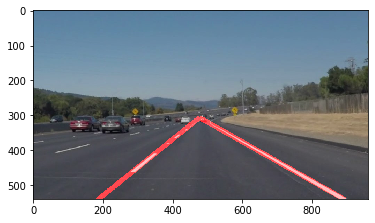

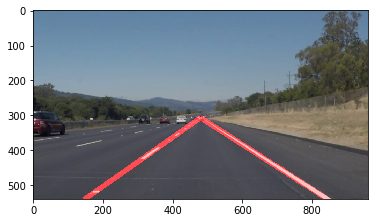

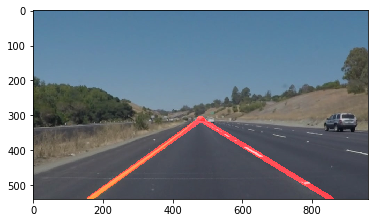

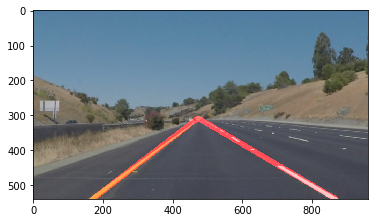

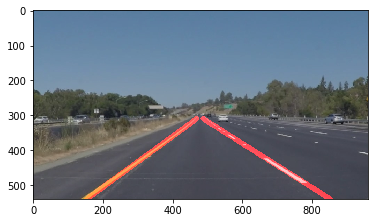

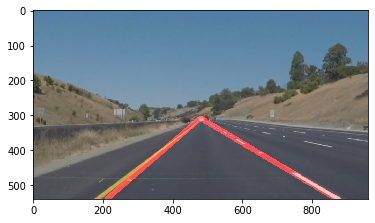

In [8]:
#reading in an image
for index, img in enumerate(os.listdir("test_images/")):
    image = mpimg.imread('test_images/' + img)
     
    gray_img = grayscale(image)    

    hsv_img = hsv(image)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    # Bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img,hough_rho,hough_theta,hough_threshold,hough_min_line_length,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
 
    fig = plt.figure(figsize=(6,10))
    plt.imshow(result, cmap="gray")  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


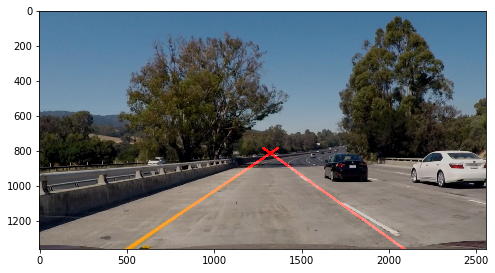

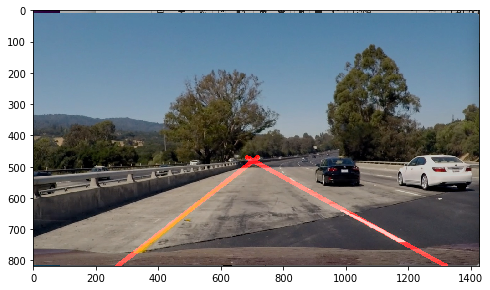

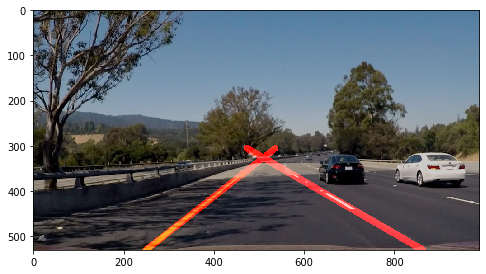

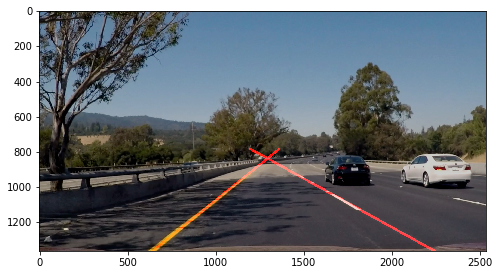

In [9]:
#reading in an image
for index, img in enumerate(os.listdir("test_images2/")):
    image = mpimg.imread('test_images2/' + img)
    
    gray_img = grayscale(image)    

    hsv_img = hsv(image)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    # Bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img,hough_rho,hough_theta,hough_threshold,hough_min_line_length,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)

    fig = plt.figure(figsize=(8,10))
    plt.imshow(result, cmap="gray")  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
       
    gray_img = grayscale(image)    

    hsv_img = hsv(image)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    # Bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img,hough_rho,hough_theta,hough_threshold,hough_min_line_length,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
    
    #return cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)
    return result

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 9min 5s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4



Moviepy - Done !
Moviepy - video ready yellow.mp4
Wall time: 32min 5s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))